<a href="https://colab.research.google.com/github/Ahamed-h/Skin_cancer_detection_using_cnn/blob/main/skin_cancer_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install  kagglehub[pandas-datasets] tensorflow matplotlib scikit-learn

In [2]:
import tensorflow as tf
import os
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub as k
from kagglehub import KaggleDatasetAdapter


# Load HAM10000 metadata

In [3]:

df = k.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "kmader/skin-cancer-mnist-ham10000",
    "HAM10000_metadata.csv"
)
print(df.head())


/tmp/ipython-input-1946628206.py:1: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = k.load_dataset(


     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear


# Map images to labels (benign=0, malignant=1)

In [4]:

benign = ["nv", "bkl", "df", "vasc"]   # benign classes
df["binary_label"] = df["dx"].apply(lambda x: 0 if x in benign else 1)

# Path to image folder (auto downloaded by kagglehub inside ~/.cache)
dataset_path = k.dataset_download("kmader/skin-cancer-mnist-ham10000")

# Load images as arrays

In [5]:

def load_image(img_id, label):
    img_path_part1 = os.path.join(dataset_path, "HAM10000_images_part_1", f"{img_id}.jpg")
    img_path_part2 = os.path.join(dataset_path, "HAM10000_images_part_2", f"{img_id}.jpg")

    if os.path.exists(img_path_part1):
        img_path = img_path_part1
    elif os.path.exists(img_path_part2):
        img_path = img_path_part2
    else:
        raise FileNotFoundError(f"Image file not found for {img_id}")

    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(128,128))
    img = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    return img, label

X, y = zip(*[load_image(row["image_id"], row["binary_label"]) for _, row in df.iterrows()])
X, y = np.array(X), np.array(y)


# Train-test split

In [6]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)



Build CNN model

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(128, 128, 3)), # Use Input layer
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train model

In [8]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=32)

Epoch 1/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - accuracy: 0.7757 - loss: 0.6477 - val_accuracy: 0.8043 - val_loss: 0.4427
Epoch 2/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.8103 - loss: 0.4047 - val_accuracy: 0.8088 - val_loss: 0.4138
Epoch 3/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.8179 - loss: 0.3833 - val_accuracy: 0.8058 - val_loss: 0.4082
Epoch 4/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8238 - loss: 0.3761 - val_accuracy: 0.8148 - val_loss: 0.3859
Epoch 5/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.8254 - loss: 0.3771 - val_accuracy: 0.8263 - val_loss: 0.3844


# Evaluate

In [9]:

loss, acc = model.evaluate(X_test, y_test)
print(f"✅ Test Accuracy: {acc:.2f}")



63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8436 - loss: 0.3733
✅ Test Accuracy: 0.83


# Plot accuracy

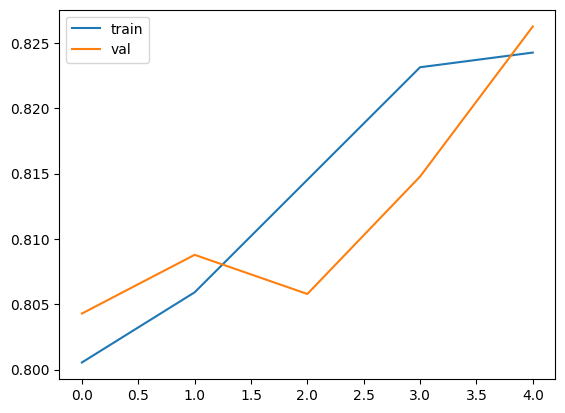

In [10]:

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.show()

In [11]:
model.save("model.keras")